In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bisect
import os
import pickle
import skopt
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from skopt.plots import (plot_convergence, plot_evaluations, plot_objective)
warnings.filterwarnings(action='ignore')
plt.style.use('seaborn')

In [3]:
def dump_pickle(file_path, obj):
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)
        
        
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        obj = pickle.load(f)
    return obj

# 1. 데이터 불러오기

In [4]:
X_train = pd.read_csv('./data/train_data.csv') 
reg_y_train = pd.read_csv('./data/train_target.csv')
clf_y_train = pd.read_csv('./data/train_target2.csv')
X_test = pd.read_csv('./data/test_data.csv') 

### 1.1 데이터셋 구조 파악
피쳐는 총 46개이며 훈련 데이터셋은 83,564개의 관측치(87.79%), 시험 데이터셋은 11,618개의 관측치(12.21%)를 갖고 있다. 

In [5]:
print('훈련 데이터셋 - 행의 수: %d, 열의 수: %d' % X_train.shape)
print('퀴즈 데이터셋 - 행의 수: %d, 열의 수: %d' % X_test.shape)

훈련 데이터셋 - 행의 수: 83564, 열의 수: 48
퀴즈 데이터셋 - 행의 수: 11618, 열의 수: 48


In [6]:
all_feature_names = sorted(list(set(X_train.columns).difference(set(['td', 'code']))))

단위 시간은 훈련 데이터셋의 경우 T001부터 T274까지 총 274개 단위(88.39%), 시험 데이터셋의 경우 T275부터 T310까지 총 36개 단위(11.61%) 존재한다. 

In [7]:
print('훈련 데이터셋 - 단위 시간 수: %d, 최초 단위 시간: %s, 최종 단위 시간: %s' % (
    X_train['td'].nunique(), X_train['td'].min(), X_train['td'].max()))
print('시험 데이터셋 - 단위 시간 수:  %d, 최초 단위 시간: %s, 최종 단위 시간: %s' % (
    X_test['td'].nunique(), X_test['td'].min(), X_test['td'].max()))

훈련 데이터셋 - 단위 시간 수: 274, 최초 단위 시간: T001, 최종 단위 시간: T274
시험 데이터셋 - 단위 시간 수:  36, 최초 단위 시간: T275, 최종 단위 시간: T310


주식 종목은 훈련 데이터셋의 경우 총 665종목, 시험 데이터셋의 경우 총 403종목 갖고 있다. 이때 'A001' 등 24개의 종목은 훈련 데이터셋에 없고 시험 데이터셋에만 존재한다. 즉 **종목마다 따로 모델링하거나 별도의 파라미터를 학습하거나 종목명을 피쳐로 사용하는 식의 접근법이 어렵거나 잘 동작하지 않을 수 있음**을 의미한다.

In [8]:
code_names_in_train = set(X_train['code'].unique())
code_names_in_test = set(X_test['code'].unique())

print('훈련 데이터셋 - 종목 수: %d, 시험 데이터셋 - 종목 수: %d' % (len(code_names_in_train), len(code_names_in_test)))
print('공통 종목 수: %d, 훈련 데이터셋에만 있는 종목 수: %d, 시험 데이터셋에만 있는 종목 수: %d' % (
    len(code_names_in_train & code_names_in_test), len(code_names_in_train.difference(code_names_in_test)),  
    len(code_names_in_test.difference(code_names_in_train))))

훈련 데이터셋 - 종목 수: 665, 시험 데이터셋 - 종목 수: 403
공통 종목 수: 379, 훈련 데이터셋에만 있는 종목 수: 286, 시험 데이터셋에만 있는 종목 수: 24


단위 시간마다 모든 종목의 관측값을 갖고 있는 것이 아니며, 당연히 종목마다 모든 단위 시간의 관측값을 갖고 있는 것이 아니다. 훈련 데이터셋의 경우 각 종목은 평균적으로 304.98개 단위 시간 관측치를 갖고 단 1개 단위의 관측치만 있는 종목들('A010' 등 27개 종목)도 존재한다. 시험 데이터셋 또한 각 종목은 평균적으로 28.83개 단위 시간 관측치를 갖고 단 1개 단위의 관측치만 있는 종목들('A107' 등 12개 종목)도 존재한다. 즉 **피쳐를 시계열 단위로 학습하는 접근법이 어렵거나 잘 동작하지 않을 수 있음**을 의미한다. 

아래 꺾은선 그래프는 단위 시간에 따른 종목 수의 추세를 보여준다. 좌측이 훈련 데이터셋, 우측이 시험 데이터셋이다.

훈련 데이터셋 - 단위 시간 당 종목 수 평균값: 304.98, 단위 시간 당 종목 수 최소값: 272, 단위 시간 당 종목 수 최대값: 339
시험 데이터셋 - 단위 시간 당 종목 수 평균값: 322.72, 단위 시간 당 종목 수 최소값: 305, 단위 시간 당 종목 수 최대값: 336


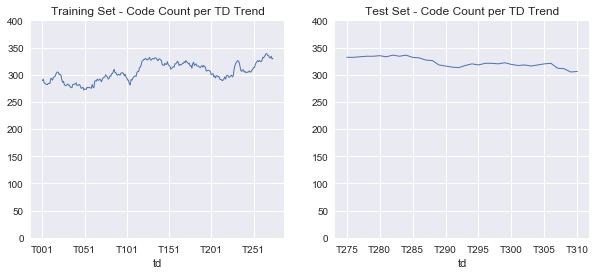

In [9]:
train_code_count_per_td = X_train.groupby('td').apply(lambda x: x['code'].nunique())
test_code_count_per_td = X_test.groupby('td').apply(lambda x: x['code'].nunique())

fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
_ = train_code_count_per_td.plot(ax=ax1, title='Training Set - Code Count per TD Trend', ylim=(0, 400), 
                                 linewidth=1.0)

ax2 = plt.subplot(1, 2, 2)
_ = test_code_count_per_td.plot(ax=ax2, title='Test Set - Code Count per TD Trend', ylim=(0, 400), linewidth=1.0)

print('훈련 데이터셋 - 단위 시간 당 종목 수 평균값: %.2f, 단위 시간 당 종목 수 최소값: %d, 단위 시간 당 종목 수 최대값: %d' % (
    train_code_count_per_td.mean(), train_code_count_per_td.min(), train_code_count_per_td.max()))
print('시험 데이터셋 - 단위 시간 당 종목 수 평균값: %.2f, 단위 시간 당 종목 수 최소값: %d, 단위 시간 당 종목 수 최대값: %d' % (
    test_code_count_per_td.mean(), test_code_count_per_td.min(), test_code_count_per_td.max()))

아래 히스토그램은 종목 별 단위 시간 수의 분포를 보여준다. 좌측이 훈련 데이터셋, 우측이 시험 데이터셋이다.

훈련 데이터셋 - 종목 당 단위 시간 수 평균값: 125.66, 종목 당 단위 시간 수 최소값: 1, 종목 당 단위 시간 수 최대값: 274
시험 데이터셋 - 종목 당 단위 시간 수 평균값:  28.83, 종목 당 단위 시간 수 최소값: 1, 종목 당 단위 시간 수 최대값:  36


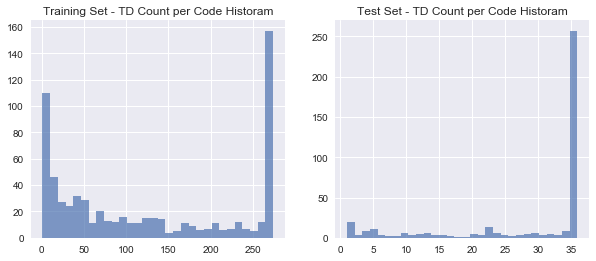

In [10]:
train_td_count_per_code = X_train.groupby('code').apply(lambda x: x['td'].nunique())
test_td_count_per_code = X_test.groupby('code').apply(lambda x: x['td'].nunique())

fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
_ = train_td_count_per_code.hist(ax=ax1, bins=30, alpha=0.7)
ax1.set_title('Training Set - TD Count per Code Historam')

ax2 = plt.subplot(1, 2, 2)
_ = test_td_count_per_code.hist(ax=ax2, bins=30, alpha=0.7)
ax2.set_title('Test Set - TD Count per Code Historam')

print('훈련 데이터셋 - 종목 당 단위 시간 수 평균값: %.2f, 종목 당 단위 시간 수 최소값: %d, 종목 당 단위 시간 수 최대값: %d' % (
    train_td_count_per_code.mean(), train_td_count_per_code.min(), train_td_count_per_code.max()))
print('시험 데이터셋 - 종목 당 단위 시간 수 평균값:  %.2f, 종목 당 단위 시간 수 최소값: %d, 종목 당 단위 시간 수 최대값:  %d' % (
    test_td_count_per_code.mean(), test_td_count_per_code.min(), test_td_count_per_code.max()))

### 1.2 결측값 비율
46개 피쳐에 대한 결측값 비율이 훈련 데이터셋은 평균 5.77%, 최대 18.76%(변수명 'F042')임을, 실험 데이터셋은 평균 7.28%, 최대 23.50%(변수명 'F042')임을 알 수 있다. **변수 제거를 고려할만큼 결측값 비율이 매우 높은 변수는 없다**고 판단된다. 

In [11]:
train_missing_value_ratios = X_train[all_feature_names].apply(lambda x: sum(x.isna()) / len(x))
test_missing_value_ratios = X_test[all_feature_names].apply(lambda x: sum(x.isna()) / len(x))

print('훈련 데이터셋 - 결측값 비율 평균값: {:0.2%}, 결측값 비율 최소값: {:0.2%}, 결측값 비율 최대값: {:0.2%}'.format(
    train_missing_value_ratios.mean(), train_missing_value_ratios.min(), 
    train_missing_value_ratios.max()))
print('시험 데이터셋 - 결측값 비율 평균값: {:0.2%}, 결측값 비율 최소값: {:0.2%}, 결측값 비율 최대값: {:0.2%}'.format(
    test_missing_value_ratios.mean(), test_missing_value_ratios.min(), test_missing_value_ratios.max()))

훈련 데이터셋 - 결측값 비율 평균값: 5.77%, 결측값 비율 최소값: 0.01%, 결측값 비율 최대값: 18.76%
시험 데이터셋 - 결측값 비율 평균값: 7.28%, 결측값 비율 최소값: 0.00%, 결측값 비율 최대값: 23.50%


# 2. 데이터셋 분할
예측 성능 확인을 위해 훈련 데이터셋의 20%를 분할하여 별도의 검증 데이터셋으로 둔다. 단위 시간 기준으로 분할하되 미래 시간대를 검증 데이터셋으로 한다. 훈련 데이터셋은 66,750개의 관측치(79.88%), 검증 데이터셋은 16,814개의 관측치(20.12%)를 갖게 된다. 

In [12]:
test_size = 0.2
train_obs_count_per_td = X_train.groupby('td')['code'].count()
split = train_obs_count_per_td.index[
    ((1.0 - train_obs_count_per_td.cumsum() / train_obs_count_per_td.sum()) <= test_size)].min()

In [13]:
def split_dataset(df, key, split):
    return df[df[key] < split].copy(), df[df[key] >= split].copy()

In [14]:
X_train, X_valid = split_dataset(X_train, 'td', split)
reg_y_train, reg_y_valid = split_dataset(reg_y_train, 'td', split)
clf_y_train, clf_y_valid = split_dataset(clf_y_train, 'td', split)

In [15]:
print('훈련 데이터셋 - 행의 수: %d, 열의 수: %d' % X_train.shape)
print('검증 데이터셋 - 행의 수: %d, 열의 수: %d' % X_valid.shape)

훈련 데이터셋 - 행의 수: 66750, 열의 수: 48
검증 데이터셋 - 행의 수: 16814, 열의 수: 48


# 3. 탐색적 자료 분석
### 3.1 타겟 분포와 기초 통계량 분석
단위 시간 수익률 기초 통계량을 구해보면 평균이 0.05%, 표준편차가 5.70%이다. 또한 정규 분포보다 오른쪽으로 약간 긴 꼬리를 갖고 있으며(왜도 > 0) 매우 뾰족한 형태(첨도 > 0)이다. 이는 **모형의 손실함수와 평가 지표가 극단값에 강건해야함**을 의미한다. 즉, **회귀보다 분류 문제로 접근하는 편이 성능 면에서 더 안정적**일 수 있다. 아래 청색 히스토그램은 단위 시간 수익률의 분포를 보여준다. 녹색 선은 평균과 표준편차가 데이터와 동일할 때 정규 분포의 확률밀도함수이다.

수익률 평균: 0.05%, 수익률 표준편차: 5.70%, 수익률 왜도: 1.19, 수익률 첨도: 22.61


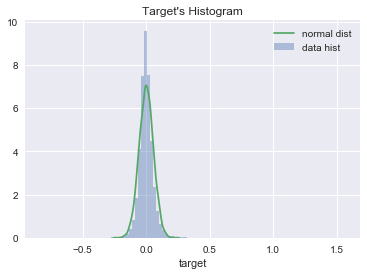

In [16]:
loc, scale = reg_y_train['target'].mean(), reg_y_train['target'].std()

fig, ax = plt.subplots(figsize=(6, 4))

_ = sns.distplot(reg_y_train['target'], bins=100, kde=False, norm_hist=True, label='data hist')
_ = sns.kdeplot(np.random.normal(size=10000, loc=loc, scale=scale), label='normal dist')
_ = ax.legend(loc='best')
_ = ax.set_title('Target\'s Histogram')

print('수익률 평균: {:0.2%}, 수익률 표준편차: {:0.2%}, 수익률 왜도: {:0.2f}, 수익률 첨도: {:0.2f}'.format(
    loc, scale, reg_y_train['target'].skew(), reg_y_train['target'].kurt()))

아래 꺾은선 그래프는 수익률 평균(좌측), 표준편차(우측)의 단위 시간에 따른 추세를 보여준다. 청색 선은 실제 관측값, 녹색 선은 지수 가중 이동 평균으로 평활화한 값이다. 이를 통해 **강한 자기상관 관계가 수익률 표준편차에 존재함**을 알 수 있다. 즉 수익률의 변동성이 커지면(또는 작아지면) 해당 크기가 한동안 지속된다. 

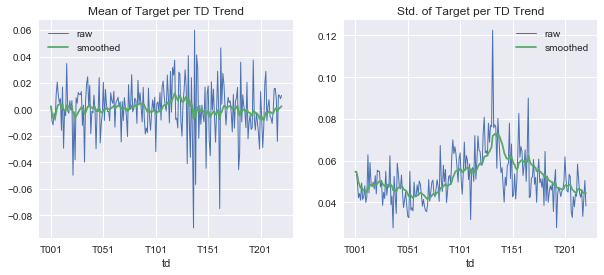

In [17]:
mean_of_target_per_td = reg_y_train.groupby('td')['target'].mean()
std_of_target_per_td = reg_y_train.groupby('td')['target'].std()

fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
_ = mean_of_target_per_td.plot(ax=ax1, title='Mean of Target per TD Trend', label='raw', linewidth=1.0)
_ = mean_of_target_per_td.ewm(span=20).mean().plot(ax=ax1, label='smoothed')
_ = ax1.legend(loc='best')

ax2 = plt.subplot(1, 2, 2)
_ = std_of_target_per_td.plot(ax=ax2, title='Std. of Target per TD Trend', label='raw', linewidth=1.0)
_ = std_of_target_per_td.ewm(span=20).mean().plot(ax=ax2, label='smoothed')
_ = ax2.legend(loc='best')

아래 히스토그램은 종목 별 수익률 평균(좌측 상단)와 표준편차(우측 상단)의 분포를 보여준다. 이를 통해 수익률 평균은 음의 왜도를, 수익률 표준편차는 양의 왜도를 갖고 있음을 알 수 있다. 따라서 **수익률 분포 중심에서 떨어진 큰 손실 또는 높은 변동성을 갖는 종목들이 일부 존재**한다. 좌측 하단은 종목 별 수익률 평균과 표준편차의 산점도로써, 약한 음의 상관관계(-27.16%)를 갖는다. 종목 수익률 간 상관계수를 구해보면 평균이 11.81%로 서로 약한 양의 상관 관계를 가짐을 알 수 있다. 우측 하단 히스토그램은 종목 수익률 간 상관계수 분포를 보여준다. 

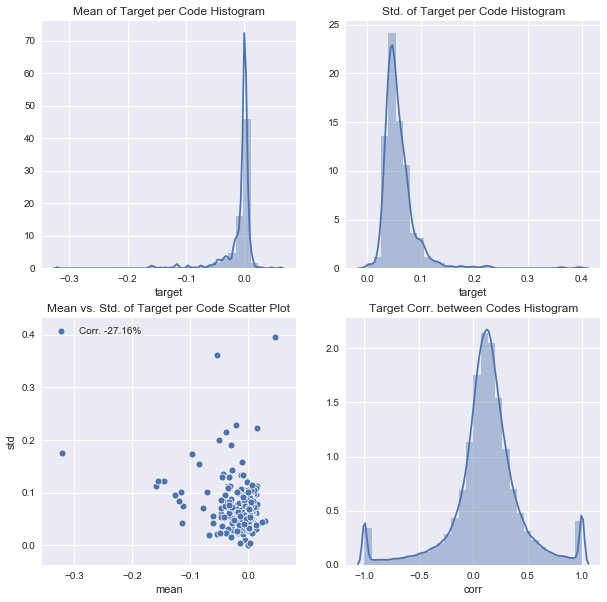

In [18]:
mean_of_target_per_code = reg_y_train.groupby('code')['target'].mean()
std_of_target_per_code = reg_y_train.groupby('code')['target'].std().dropna()
stats_of_target_per_code = pd.DataFrame(
    {'mean': mean_of_target_per_code, 'std': std_of_target_per_code}).dropna()
target_corr_between_codes = reg_y_train.set_index(['td', 'code']).unstack().corr()

corrs = dict()
for i in range(target_corr_between_codes.shape[0]):
    for j in range(target_corr_between_codes.shape[1]):
        if i > j and not np.isnan(target_corr_between_codes.iloc[i, j]):
            corrs[(target_corr_between_codes.index[i][1], target_corr_between_codes.columns[j][1])] = \
            target_corr_between_codes.iloc[i, j]
corrs = pd.Series(corrs, name='corr')   

fig = plt.figure(figsize=(10, 10))

ax1 = plt.subplot(2, 2, 1)
_ = sns.distplot(mean_of_target_per_code, bins=30)
_ = ax1.set_title('Mean of Target per Code Histogram')

ax2 = plt.subplot(2, 2, 2)
_ = sns.distplot(std_of_target_per_code, bins=30)
_ = ax2.set_title('Std. of Target per Code Histogram')

ax3 = plt.subplot(2, 2, 3)
sns.scatterplot(x='mean', y='std', data=stats_of_target_per_code, 
                label='Corr. {:0.2%}'.format(stats_of_target_per_code.corr().iloc[0, 1]))
_ = ax3.set_title('Mean vs. Std. of Target per Code Scatter Plot')

ax4 = plt.subplot(2, 2, 4)
_ = sns.distplot(corrs, bins=30)
_ = ax4.set_title('Target Corr. between Codes Histogram')

### 3.2 피쳐 분포와 기초 통계량 분석
아래 히스토그램은 총 46개 피쳐의 분포를 보여준다. 이를 통해 7개의 범주를 갖는 **'F40'을 제외하곤 모두 수치형 변수임**을 알 수 있다. 정규 분포 또는 로그 정규 분포를 따르는 변수들이 보이고 극단값이 두텁게 존재하는 변수들도 일부 보인다.

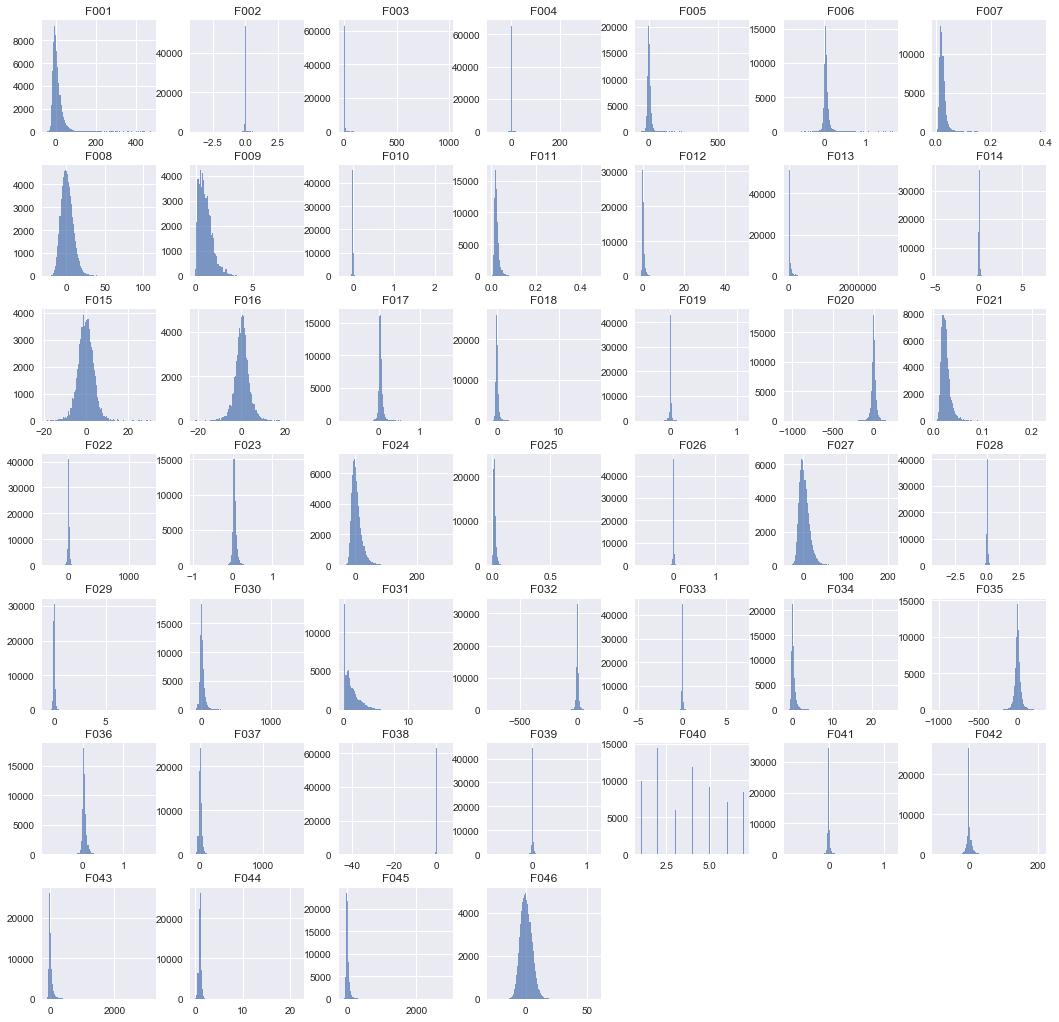

In [19]:
_ = X_train[all_feature_names].hist(figsize=(18, 18), bins=100, alpha=0.7)

cat_feature_names = ['F040']
num_feature_names = sorted(list(set(all_feature_names).difference(set(cat_feature_names))))

아래 꺾은선 그래프는 45개 수치형 변수 평균의 단위 시간에 따른 추세를 보여준다. 실선 위, 아래로 존재하는 점선은 표본 평균의 95% 신뢰 상, 하한값이다. **변수에 따라 증감하는 추세성이나 반복되는 계절성 또는 주기성이 뚜렷하게 드러나는 경우가 있다.**

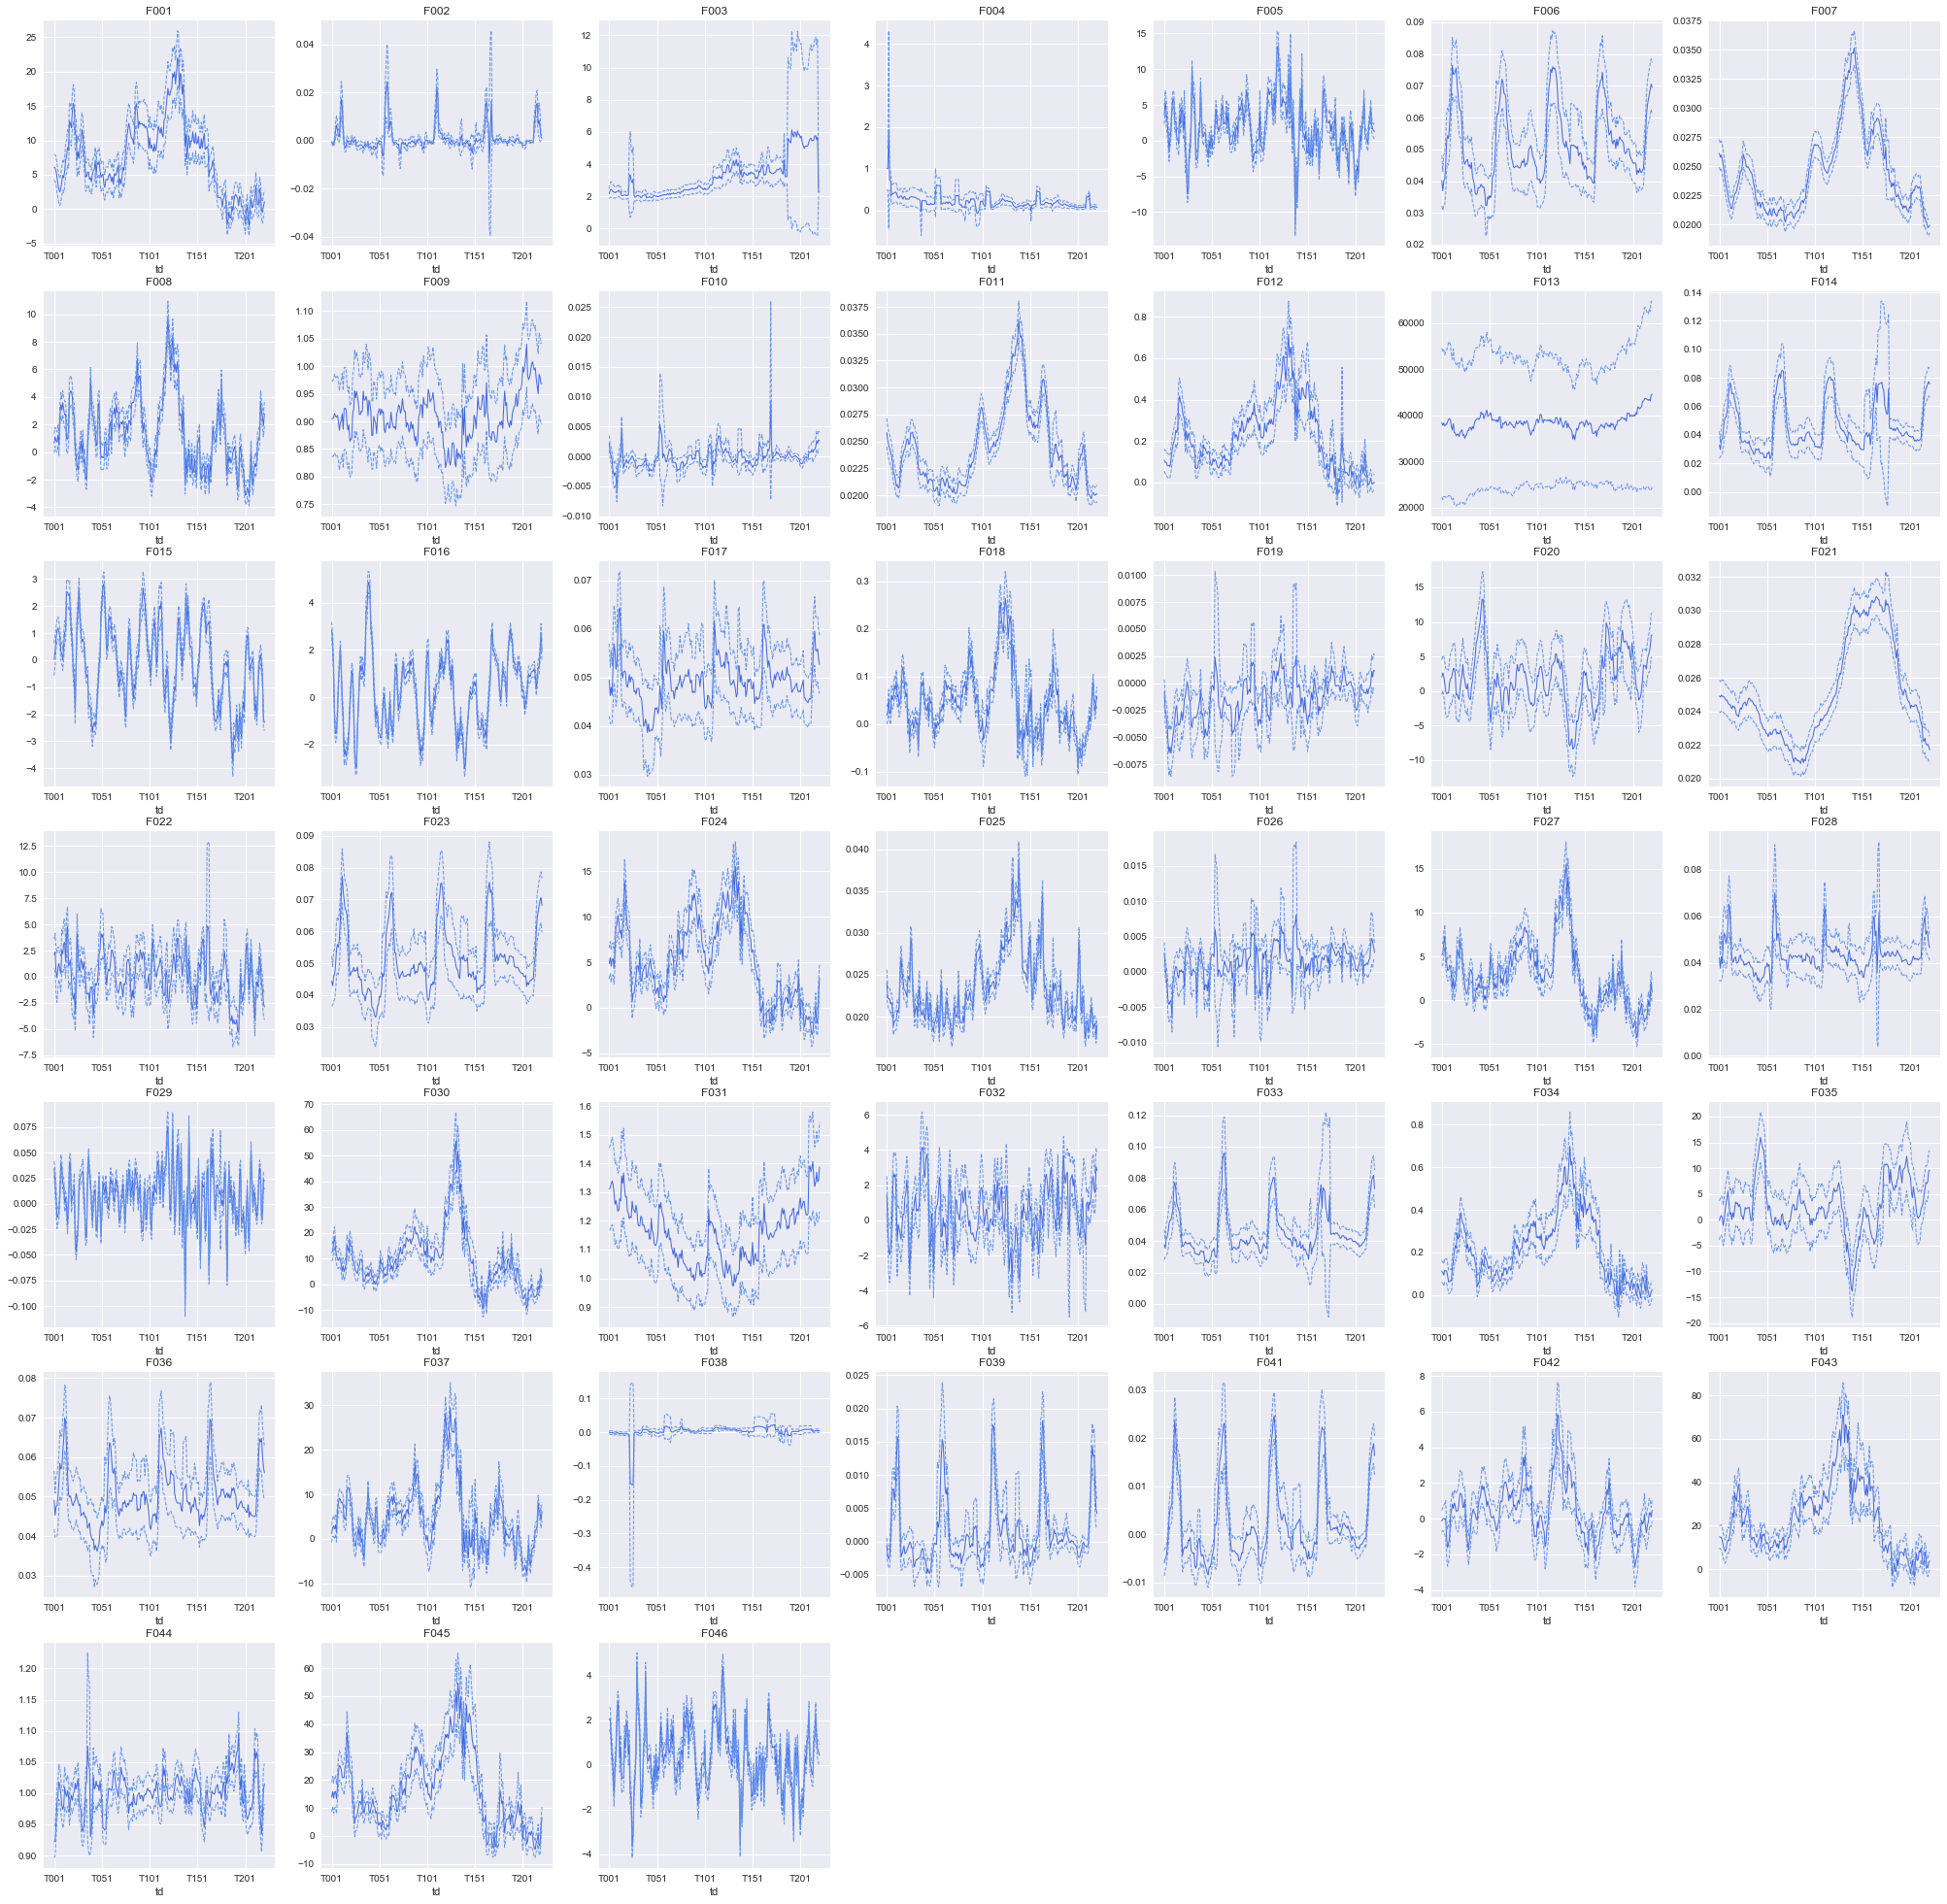

In [20]:
n_plots_per_row = 7
n_plots_per_column = len(num_feature_names) // n_plots_per_row 
if len(num_feature_names) % n_plots_per_row > 0:
    n_plots_per_column += 1
    
z_score = stats.norm.ppf(0.975)
mean_of_features_per_td = X_train.groupby('td')[num_feature_names].mean()
conf_invervals = z_score * X_train.groupby('td')[num_feature_names].std() / np.sqrt(
    X_train.groupby('td')[num_feature_names].count())
    
fig = plt.figure(figsize=(5 * n_plots_per_row, 5 * n_plots_per_column))

for i, feature in enumerate(num_feature_names, 1):
    ax = plt.subplot(n_plots_per_row, n_plots_per_column, i)
    mean_of_features_per_td[feature].plot(ax=ax, color='royalblue', linewidth=1.0, title=feature)
    (mean_of_features_per_td[feature] + conf_invervals[feature]).plot(
        ax=ax, color='cornflowerblue', linestyle='--', linewidth=1.0)
    (mean_of_features_per_td[feature] - conf_invervals[feature]).plot(
        ax=ax, color='cornflowerblue', linestyle='--', linewidth=1.0)

아래 바이올린 플롯은 45개 수치형 변수의 종목에 따른 분포 차이를 보여준다. 각 플롯의 가로축은 시각화를 위해 무작위로 선정한 일부 종목의 목록이고 세로축은 관측된 변수값의 범위이다. **종목 간 관측값 분포가 상이한 변수가 다수 존재함**을 알 수 있다.

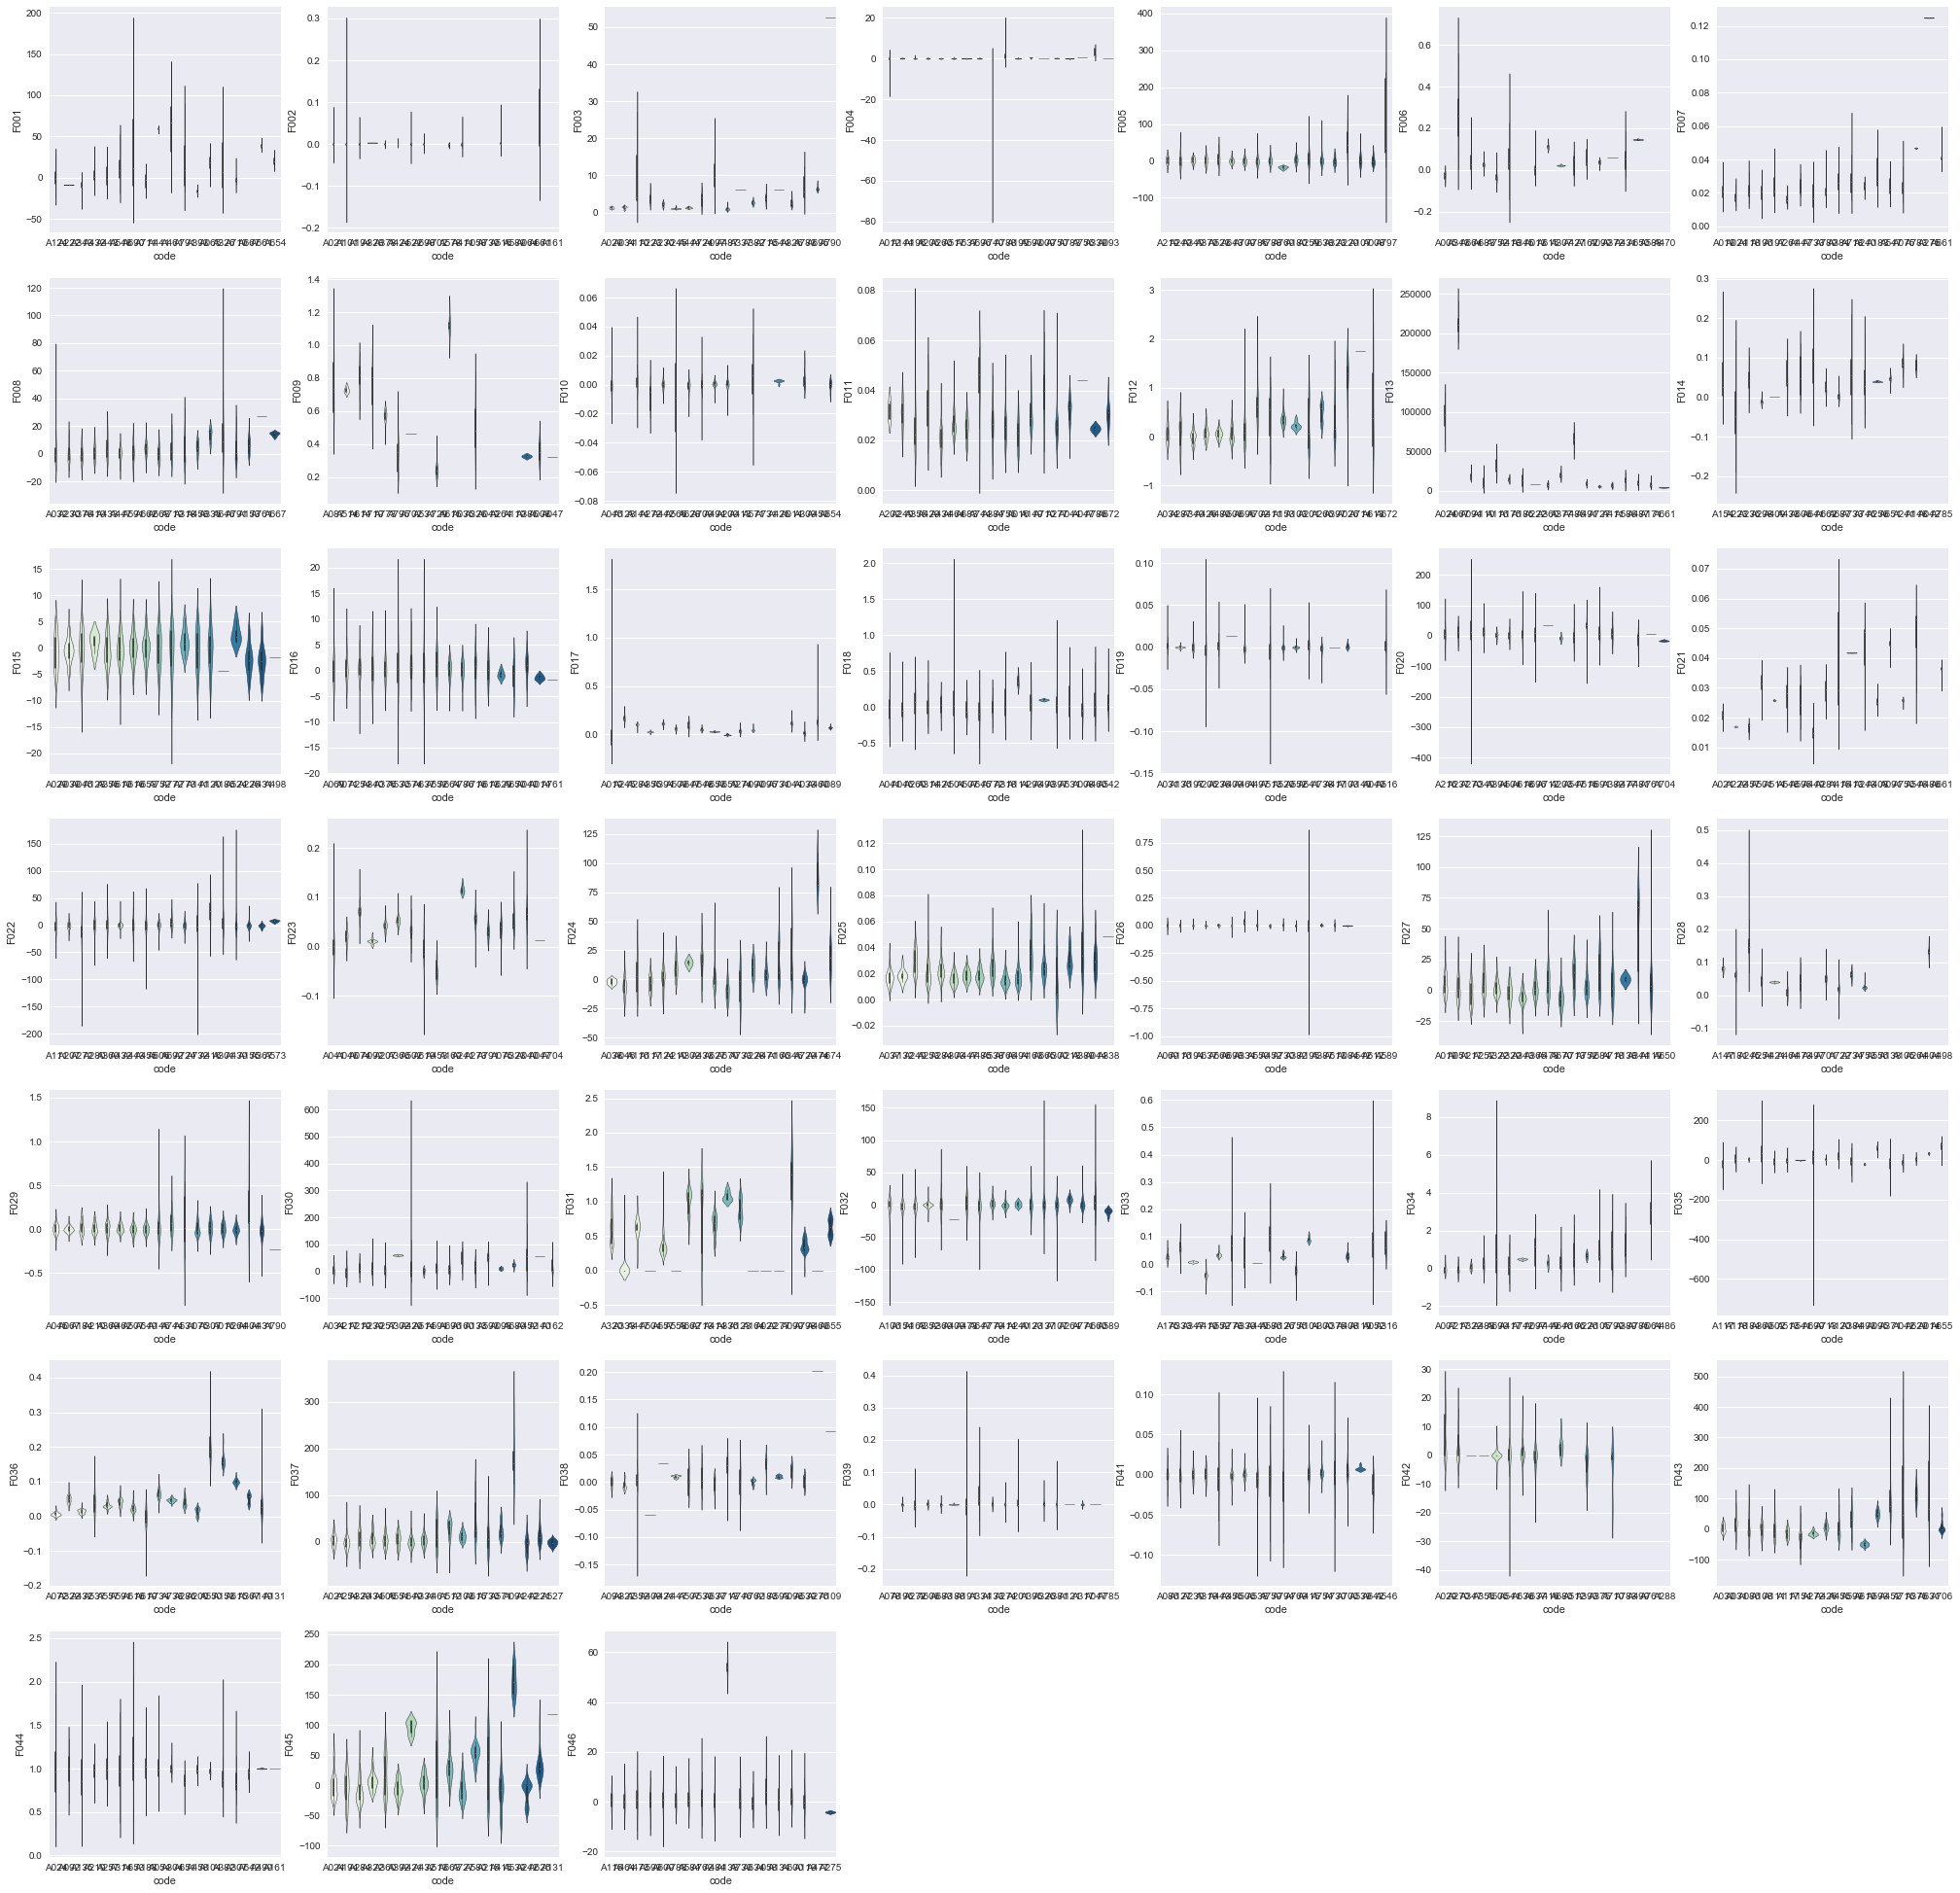

In [21]:
code_names = X_train['code'].unique()
sampling_ratio = 0.03

fig = plt.figure(figsize=(5 * n_plots_per_row, 5 * n_plots_per_column))

for i, feature in enumerate(num_feature_names, 1):
    ax = plt.subplot(n_plots_per_row, n_plots_per_column, i)
    np.random.shuffle(code_names)
    sampled_code_names = pd.Series(code_names[:int(len(code_names) * sampling_ratio)], name='code')
    _ = sns.violinplot(x='code', y=feature, data=X_train.merge(sampled_code_names, on='code', how='inner'), 
                       palette='GnBu', linewidth=0.5)

피쳐 간 상관계수를 구해보면 평균값이 14.54%, 음의 최대값(변수명 'F003'과 'F009')이 -55.92%, 양의 최대값(변수명 'F017'과 'F036')이 95.56%이다. 

피쳐 간 상관계수 평균값: 14.54%, 상관계수 음의 최대값: -55.92%, 상관계수 양의 최대값: 95.56%


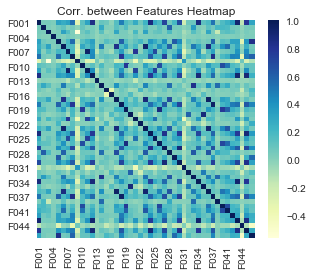

In [22]:
corr_between_features = X_train[num_feature_names].corr()
corrs = dict()
for i in range(corr_between_features.shape[0]):
    for j in range(corr_between_features.shape[1]):
        if i > j:
            corrs[(corr_between_features.index[i], 
                  corr_between_features.columns[j])] = corr_between_features.iloc[i, j]
corrs = pd.Series(corrs, name='corr')     

fig, ax = plt.subplots(figsize=(5, 4))
_ = sns.heatmap(corr_between_features, square=True, cmap='YlGnBu')
_ = ax.set_title('Corr. between Features Heatmap')

print('피쳐 간 상관계수 평균값: {:0.2%}, 상관계수 음의 최대값: {:0.2%}, 상관계수 양의 최대값: {:0.2%}'.format(
    corrs.mean(), corrs.min(), corrs.max()))

### 3.3 타겟과 피쳐 간의 상관 분석
타겟과 피쳐 간의 상관계수를 구해보면 평균값이 -0.11%, 음의 최대값(변수명 'F021')이 -3.05%, 양의 최대값(변수명 'F039')이 2.69%이다. **모든 피쳐가 타겟과의 상관 관계가 매우 약하므로 예측력 높은 모형을 만들기가 쉽지 않아 보인다.**

In [23]:
feature_corr_with_target = X_train[num_feature_names].corrwith(reg_y_train['target'])

print('타겟과의 상관계수 평균값: {:0.2%}, 상관계수 음의 최대값: {:0.2%}, 상관계수 양의 최대값: {:0.2%}'.format(
    feature_corr_with_target.mean(), feature_corr_with_target.min(), feature_corr_with_target.max()))

타겟과의 상관계수 평균값: -0.11%, 상관계수 음의 최대값: -3.05%, 상관계수 양의 최대값: 2.69%


아래 꺾은선 그래프는 단위 시간에 따른 타겟과 45개 수치형 변수 간의 상관계수 추세를 보여준다. 청색 선은 실제 관측값, 녹색 선은 지수 가중 이동 평균으로 평활화한 값이다. 대부분 0 근처에 머물지만 일부 단위 시간의 수익률은 피쳐와 상관관계가 있어 보인다.

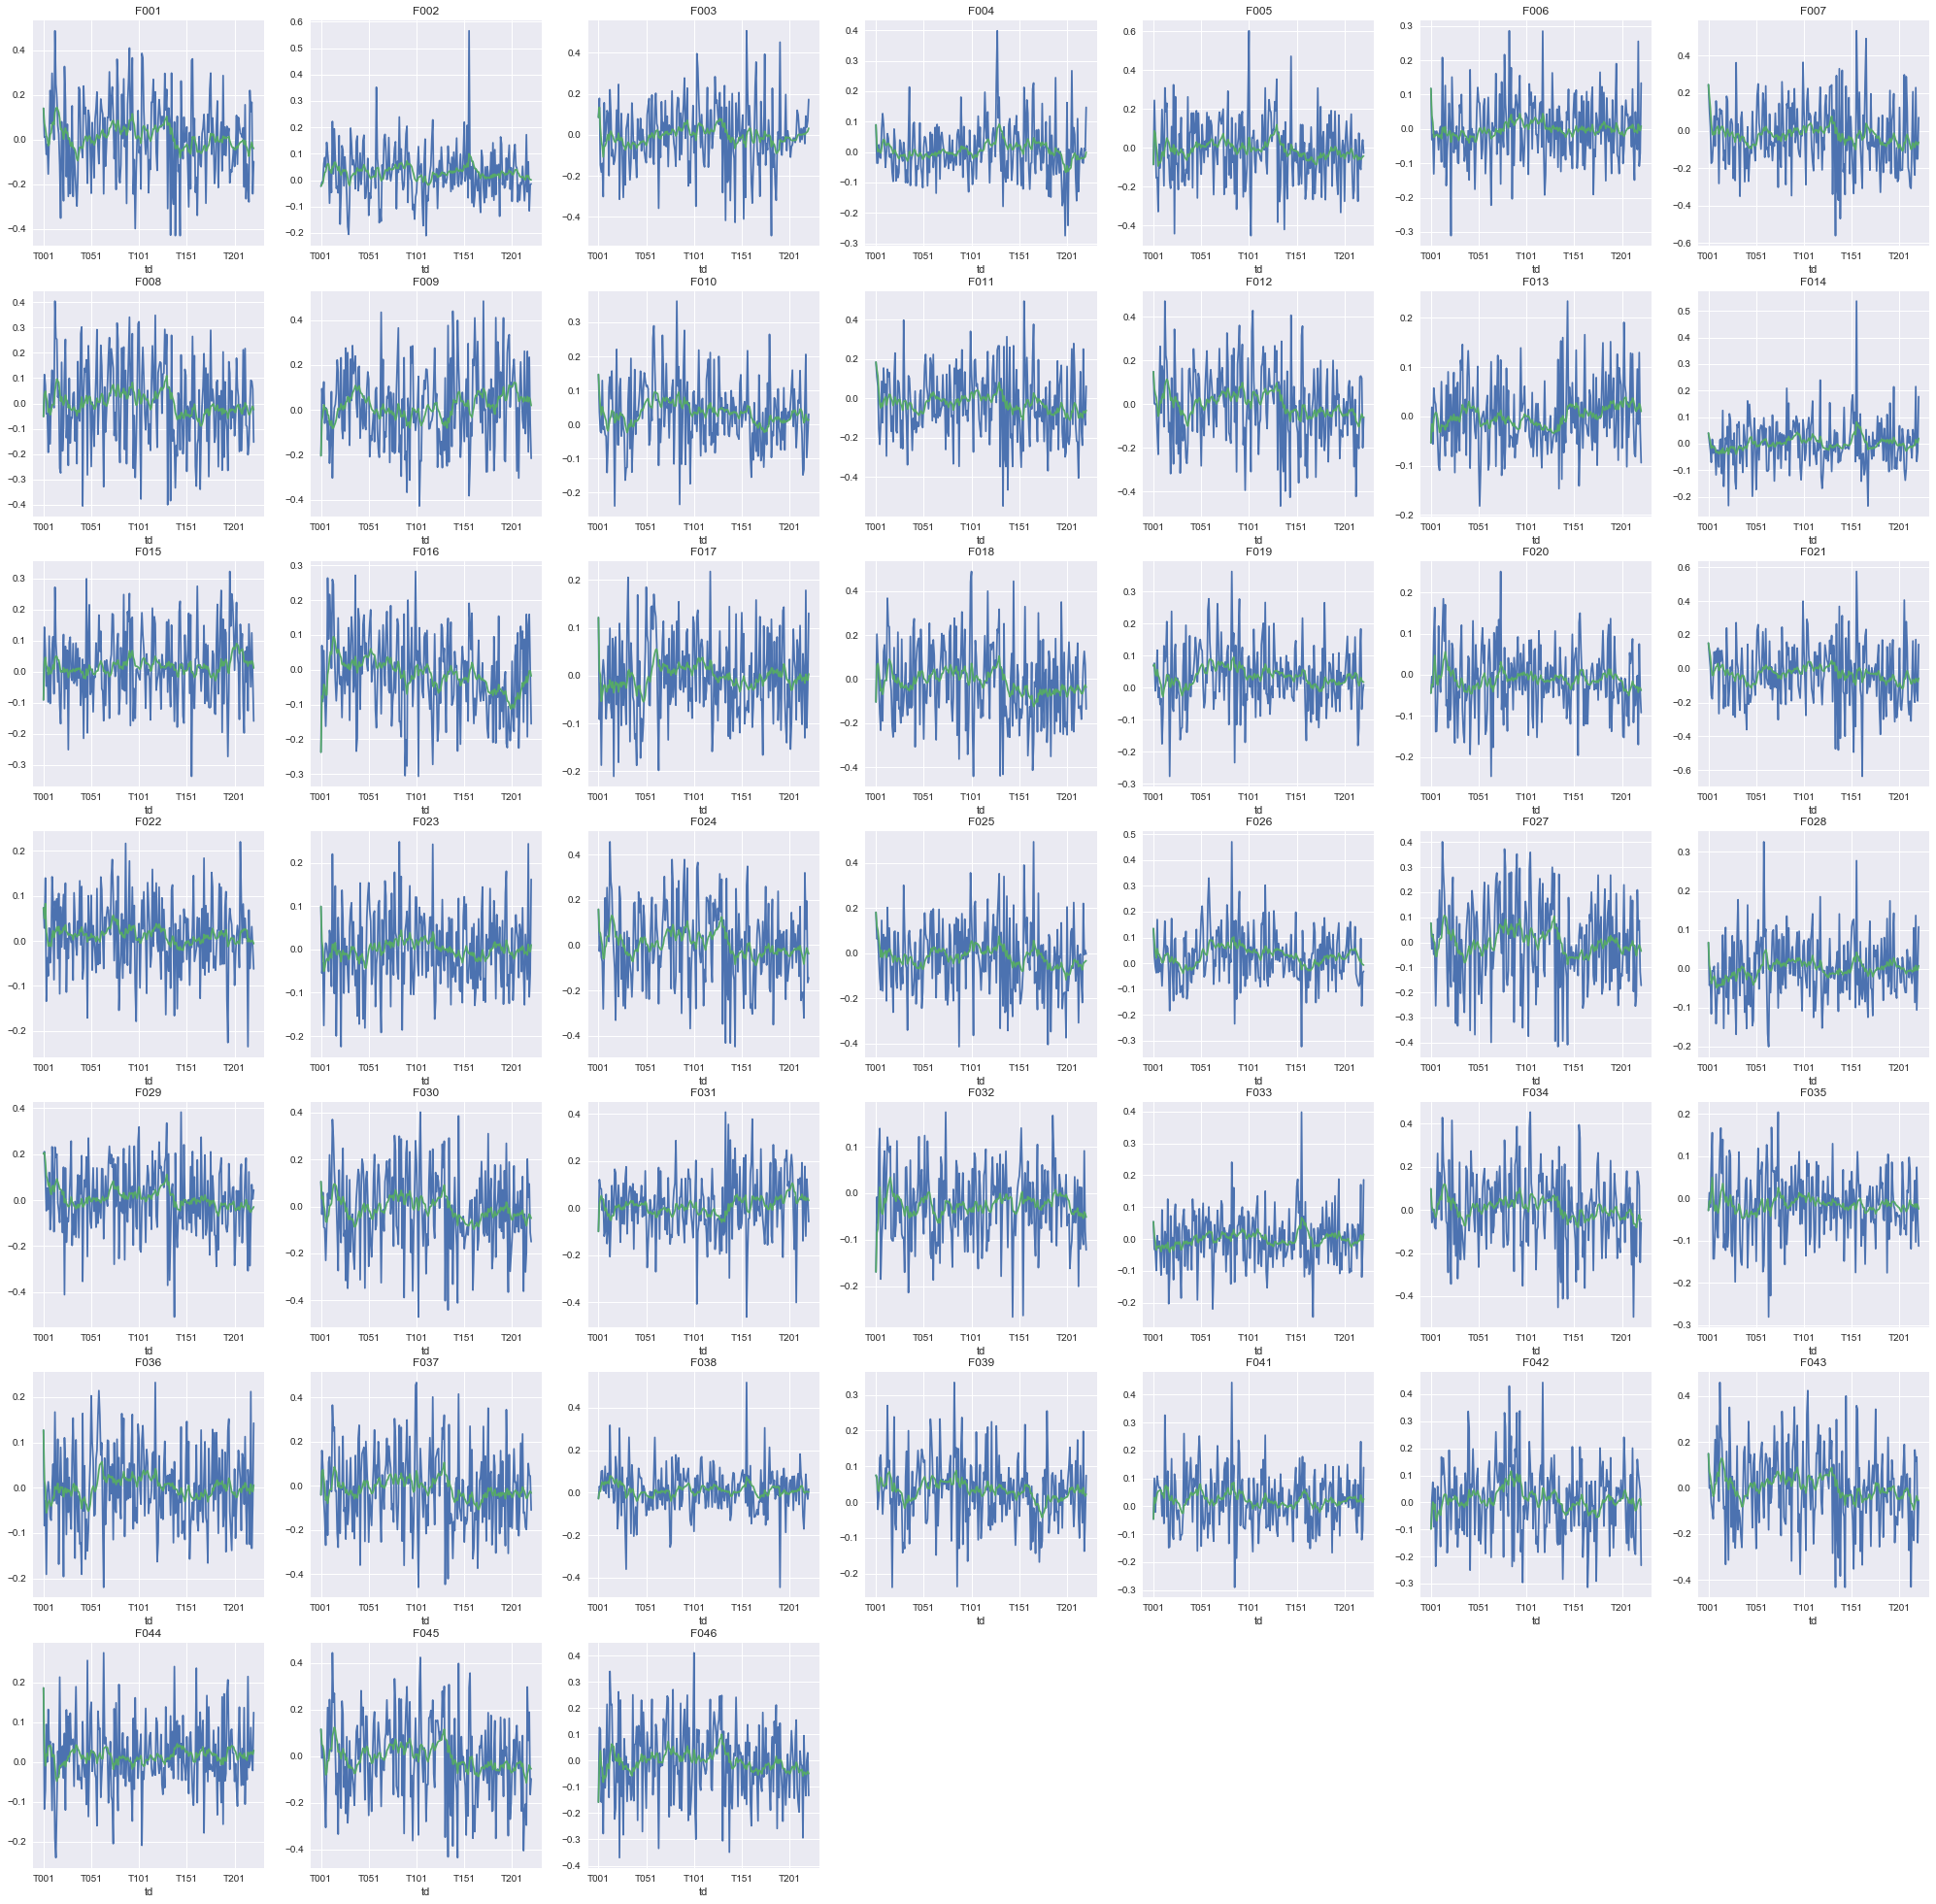

In [24]:
merged = X_train.merge(reg_y_train, on=['td', 'code'], how='inner')
feature_corr_with_target_per_td = merged.groupby('td').apply(
    lambda x: x[num_feature_names].corrwith(x['target']))

fig = plt.figure(figsize=(5 * n_plots_per_row, 5 * n_plots_per_column))

for i, feature in enumerate(num_feature_names, 1):
    ax = plt.subplot(n_plots_per_row, n_plots_per_column, i)
    _ = feature_corr_with_target_per_td[feature].plot(ax=ax, title=feature)
    _ = feature_corr_with_target_per_td[feature].ewm(span=20).mean().plot(ax=ax)

아래 히스토그램은 종목 별 타겟과 45개 수치형 변수 간의 상관계수 분포를 보여준다. 대부분 0 근처에 머물지만 일부 종목의 수익률은 피쳐와 상관관계가 있어 보인다. 위 내용을 정리하면, **예측력 높은 모형을 만들기 위해서 단위 시간과 종목, 피쳐의 3차원 데이터 구조를 잘 활용할 수 있는 아키텍쳐를 고려해야 한다.**

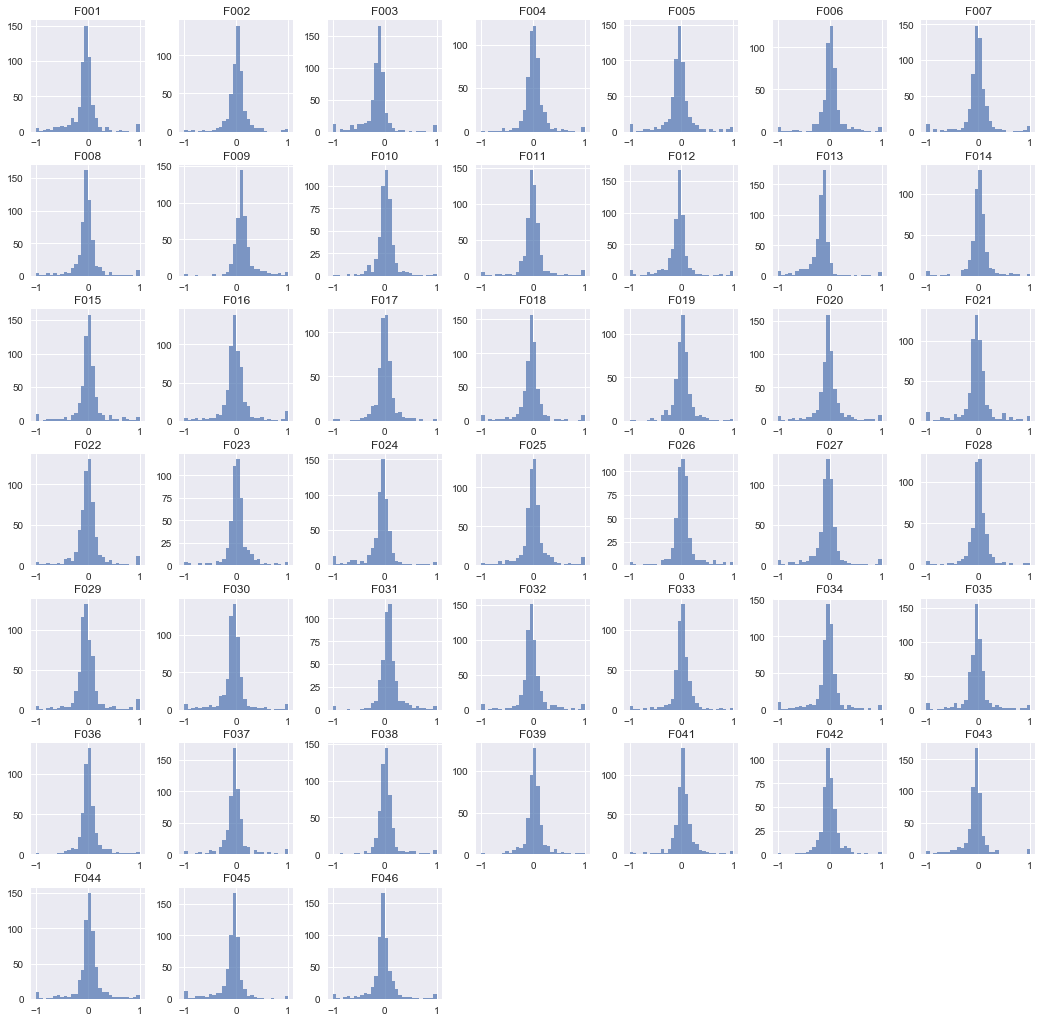

In [25]:
feature_corr_with_target_per_code = merged.groupby('code').apply(
    lambda x: x[num_feature_names].corrwith(x['target']))

_ = feature_corr_with_target_per_code.hist(figsize=(18, 18), bins=30, alpha=0.7)

# 4. 모델 프로토타이핑
### 4.1 데이터 전처리
모델링을 진행하기 앞서 데이터 전처리를 수행해야 한다. 먼저 모든 피쳐에 대해 **결측값 대체를 진행**한다. **범주형 변수의 경우** 범주 개수가 매우 많다면 임베딩 처리해야하지만 본 데이터셋은 그렇지 않으므로 **원-핫 인코딩으로 처리**한다. **수치형 변수의 경우 오른쪽으로 긴 꼬리를 갖는 변수**(왜도 > 0)는 **로그 변환**을 통해 정규 분포에 가깝게 만들어주고 **최대 - 최소값으로 스케일링 작업**을 수행한다.

In [26]:
proc_X_train = X_train.copy()
proc_X_valid = X_valid.copy()

In [27]:
skewed_feature_names = sorted(list((proc_X_train[all_feature_names].columns[
    proc_X_train[all_feature_names].skew() > z_score] & (proc_X_train[all_feature_names].columns[
    proc_X_train[all_feature_names].min() > 0.0]))))

proc_X_train[skewed_feature_names] = np.log(1.0 + proc_X_train[skewed_feature_names])
proc_X_valid[skewed_feature_names] = np.log(1.0 + proc_X_valid[skewed_feature_names])

In [28]:
cat_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0.0), 
                             OneHotEncoder(sparse=False, handle_unknown='ignore'))
num_pipeline = make_pipeline(MinMaxScaler(), SimpleImputer(strategy='constant', fill_value=-1.0))
column_transformer = make_column_transformer((cat_pipeline, cat_feature_names), 
                                             (num_pipeline, num_feature_names))

In [29]:
n_categories = X_train[cat_feature_names[0]].nunique() + 1
cat_proc_feature_names = ['_'.join([cat_feature_names[0], str(i)]) for i in range(n_categories)]
all_proc_feature_names = num_feature_names + cat_proc_feature_names

In [30]:
proc_X_train = column_transformer.fit_transform(proc_X_train)
proc_X_train = pd.DataFrame(proc_X_train, columns=all_proc_feature_names, index=X_train.index)

proc_X_valid = column_transformer.transform(proc_X_valid)
proc_X_valid = pd.DataFrame(proc_X_valid, columns=all_proc_feature_names, index=X_valid.index)

### 4.2 모델링 (완전 연결 신경망)
모형 예측 성능을 비교할 최저 기준을 구해보자. **클래스 불균형 문제가 없으므로 정확도를 주요 평가 지표로 정한다.** 훈련 데이터셋의 최빈 클래스로 검증 데이터셋 클래스를 모두 예측할 경우 정확도 값은 아래와 같다. 이 값이 모형의 정확도가 넘어야 할, **상식 수준의 최저 기준점**이다.

In [31]:
print('상식 수준의 기준점(정확도): {0:0.2%}'.format(
    clf_y_valid[clf_y_valid['target'] == clf_y_train['target'].mode()[0]].shape[0] / clf_y_valid.shape[0]))

상식 수준의 기준점(정확도): 20.12%


In [32]:
model_dir = os.path.abspath('models')

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

첫번째 완전 연결 신경망 모형은 **3개의 완전 연결 층을 쌓아서 만들었다.** **다중 클래스 분류 문제이므로 마지막 층 활성화 함수로 소프트맥스, 손실 함수로 범주형 크로스 엔트로피를 지정**했다. **과적합 방지를 위해 가중치 규제와 드롭 아웃, 배치 정규화를 설정**했다.

In [33]:
n_features = len(all_proc_feature_names)
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_dir, 'best_simple_dnn.h5'), monitor='val_acc', save_best_only=True)]
regularizer = tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)

simple_dnn = tf.keras.models.Sequential()
simple_dnn.add(tf.keras.layers.Dense(64, kernel_regularizer=regularizer, activation='relu', 
                                     input_shape=(n_features, )))
simple_dnn.add(tf.keras.layers.BatchNormalization())
simple_dnn.add(tf.keras.layers.Dropout(0.1, seed=42))
simple_dnn.add(tf.keras.layers.Dense(32, kernel_regularizer=regularizer, activation='relu'))
simple_dnn.add(tf.keras.layers.BatchNormalization())
simple_dnn.add(tf.keras.layers.Dropout(0.1, seed=42))
simple_dnn.add(tf.keras.layers.Dense(5, activation='softmax'))

simple_dnn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [34]:
if not os.path.isfile(os.path.join(model_dir, 'simple_dnn.h5')):
    epochs = 200
    batch_size = 16384

    training_data = (proc_X_train[all_proc_feature_names], clf_y_train['target'])
    validation_data = (proc_X_valid[all_proc_feature_names], clf_y_valid['target'])

    history = simple_dnn.fit(*training_data, validation_data=validation_data, 
                             batch_size=batch_size, epochs=epochs, verbose=False, callbacks=callbacks)
    history = history.history

    simple_dnn.save(os.path.join(model_dir, 'simple_dnn.h5'))
    dump_pickle(os.path.join(model_dir, 'simple_dnn_history.pkl'), history)
    
else:
    simple_dnn = tf.keras.models.load_model(os.path.join(model_dir, 'simple_dnn.h5'))
    history = load_pickle(os.path.join(model_dir, 'simple_dnn_history.pkl'))

In [35]:
def show_metrics_per_epoch(history, smoothing=False):
    metrics_per_epoch = pd.DataFrame(history)
    
    if smoothing:
        losses = metrics_per_epoch['loss'].rolling(window=10).mean()
        val_losses = metrics_per_epoch['val_loss'].rolling(window=10).mean()
        accuracies = metrics_per_epoch['acc'].rolling(window=10).mean()
        val_accuracies = metrics_per_epoch['val_acc'].rolling(window=10).mean()
        
    else:
        losses = metrics_per_epoch['loss']
        val_losses = metrics_per_epoch['val_loss']
        accuracies = metrics_per_epoch['acc']
        val_accuracies = metrics_per_epoch['val_acc']
    
    fig = plt.figure(figsize=(10, 4))

    ax1 = plt.subplot(1, 2, 1)
    _ = ax1.plot(losses, linewidth=1.2, label='Training Loss')
    _ = ax1.plot(val_losses, linestyle='--', linewidth=1.2, label='Validation Loss')
    _ = ax1.set_title('Loss per Epoch')
    _ = ax1.legend(loc='best')
        
    ax2 = plt.subplot(1, 2, 2)
    _ = ax2.plot(accuracies, linewidth=1.2, label='Training Accuracy')
    _ = ax2.plot(val_accuracies, linestyle='--', linewidth=1.2, label='Validation Accuracy')
    _ = ax2.set_title('Accuracy per Epoch')
    _ = ax2.legend(loc='best')
    
    print('검증 손실 최소값: {:0.2f}, 검증 정확도 최대값: {:0.2%}'.format(
        metrics_per_epoch['val_loss'].min(), metrics_per_epoch['val_acc'].max()))
    return metrics_per_epoch

첫번째 모형은 **검증 정확도를 상식 수준의 기준점에서 약 3~4%p 가량 향상**시켰다. 에폭에 따른 손실과 정확도 추세를 보면 약 100~150번 째 에폭을 지나면서 검증 손실과 정확도가 수렴하는 것처럼 보인다.

검증 손실 최소값: 1.60, 검증 정확도 최대값: 23.76%


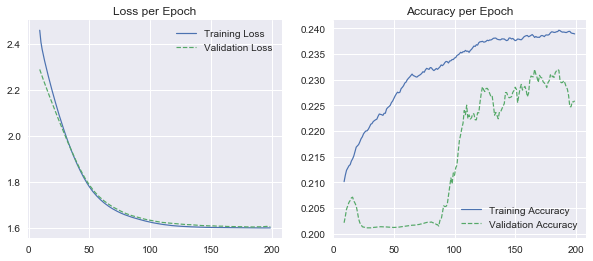

In [36]:
metrics_per_epoch = show_metrics_per_epoch(history, smoothing=True)

**개별 종목명을 모델 아키텍쳐에 명시적으로 반영하는 접근법**을 고려해보자. 606개 종목명을 각각 범주로 하는 단일 피쳐를 생성하여 모형에 추가한다. 여기서 문제는 검증 데이터셋에 있지만 훈련 데이터셋에는 없는 종목 59개가 따로 존재한다는 것이다. 이를 해결하기 위해 다음과 같은 트릭을 사용했다. 
* 각 범주(종목명)를 정수로 연결하는 `OridinalEncoder`에 \'<unknown\>' 범주를 의도적으로 추가한다. 
* 검증 데이터셋에만 존재하는 종목은 모형이 \'<unknown\>' 범주로써 처리하게끔 한다. 
* 그러나 원천 훈련 데이터셋에 범주가 \'<unknown\>'인 종목이 따로 없으므로 관련 모델 파라미터를 학습할 방법이 없다. 검증 데이터셋에만 존재하는 종목은 훈련 데이터셋에서 종목명을 제외한 나머지 피쳐들(그와 관련한 파라미터)로 예측되길 바란다. 이러한 연유로 훈련 데이터셋에서 일부 관측치를 무작위로 추출한다음 \'<unknown\>' 범주를 부여하고 기존 데이터셋에 덧붙인다. 
* 새롭게 만든 훈련 데이터셋으로 학습을 진행한다.

In [37]:
code_added_X_train = proc_X_train.copy()
code_added_X_valid = proc_X_valid.copy()

In [38]:
enc_feature_names = ['code']
encoder = OrdinalEncoder().fit(X_train[enc_feature_names])
categories = list(encoder.categories_[0])
bisect.insort_left(categories, '<unknown>')
encoder.categories_[0] = np.array(categories) 

In [39]:
enc_X_train = encoder.transform(X_train[enc_feature_names])
enc_X_valid = encoder.transform(
    pd.DataFrame(X_valid[enc_feature_names[0]].apply(lambda x: '<unknown>' if x not in categories else x)))

code_added_X_train[enc_feature_names[0]] = enc_X_train
code_added_X_valid[enc_feature_names[0]] = enc_X_valid

code_added_cat_feature_names = cat_proc_feature_names + enc_feature_names
code_adeed_all_feature_names = all_proc_feature_names + enc_feature_names

In [40]:
sampling_size = 0.1
sampled_X_train = code_added_X_train.sample(frac=sampling_size, replace=False, random_state=42)
sampled_X_train['code'] = float(categories.index('<unknown>'))
sampled_y_train = reg_y_train.loc[sampled_X_train.index]
augmented_X_train = pd.concat([code_added_X_train, sampled_X_train], axis=0) 
augmented_y_train = pd.concat([clf_y_train, sampled_y_train], axis=0) 

두번째 완전 연결 신경망 모형은 첫번째 모형 구조와 거의 같지만 **각 종목명을 범주로 하는 피쳐를 사용한다**는 점이 다르다. 해당 피쳐는 범주가 600개 이상이기 때문에 **임베딩 층을 이용하여 별도 처리**한 뒤 다른 피쳐의 활성화 값들과 결합시킨다.

In [41]:
n_categories = len(categories)
n_features = len(code_adeed_all_feature_names)
embedding_size = int(min(np.ceil(0.5 * n_categories), 64))

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_dir, 'best_code_added_dnn.h5'), monitor='val_acc', save_best_only=True)]
regularizer = tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)

cat_inputs = tf.keras.Input(shape=(1, ), dtype='int32', name='cat_features')
embedded = tf.keras.layers.Embedding(n_categories, embedding_size)(cat_inputs)
embedded = tf.keras.layers.Reshape((embedding_size, ))(embedded)

num_inputs = tf.keras.Input(shape=(n_features - 1, ), name='num_features')
activated = tf.keras.layers.Dense(64, kernel_regularizer=regularizer, activation='relu')(num_inputs)
activated = tf.keras.layers.BatchNormalization()(activated)
activated = tf.keras.layers.Dropout(0.25, seed=42)(activated)

concatenated = tf.keras.layers.concatenate([embedded, activated], axis=-1)
activated = tf.keras.layers.Dense(32, kernel_regularizer=regularizer, activation='relu')(concatenated)
activated = tf.keras.layers.BatchNormalization()(activated)
activated = tf.keras.layers.Dropout(0.25, seed=42)(activated)
outputs = tf.keras.layers.Dense(5, activation='softmax')(activated)
code_added_dnn = tf.keras.models.Model(inputs=[cat_inputs, num_inputs], outputs=outputs)

code_added_dnn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [42]:
if not os.path.isfile(os.path.join(model_dir, 'code_added_dnn.h5')):
    epochs = 200
    batch_size = 16384

    non_enc_feature_names = list(set(code_adeed_all_feature_names).difference(set(enc_feature_names)))
    training_data = ({'cat_features': augmented_X_train[enc_feature_names],
                      'num_features': augmented_X_train[non_enc_feature_names]}, 
                     augmented_y_train['target'])
    validation_data = ({'cat_features': code_added_X_valid[enc_feature_names],
                        'num_features': code_added_X_valid[non_enc_feature_names]}, 
                       clf_y_valid['target'])

    history = code_added_dnn.fit(*training_data, validation_data=validation_data, 
                                 batch_size=batch_size, epochs=epochs, verbose=False, callbacks=callbacks)
    history = history.history

    code_added_dnn.save(os.path.join(model_dir, 'code_added_dnn.h5'))
    dump_pickle(os.path.join(model_dir, 'code_added_dnn_history.pkl'), history)
    
else:
    code_added_dnn = tf.keras.models.load_model(os.path.join(model_dir, 'code_added_dnn.h5'))
    history = load_pickle(os.path.join(model_dir, 'code_added_dnn_history.pkl'))

두번째 모형은 첫번째 모형보다 **검증 손실과 정확도가 오히려 좋지 않다.** 이는 종목명 피쳐가 모형의 예측 편향을 줄이지 못하면서 분산만 키웠기 때문이다. 결론적으로 해당 피쳐는 사용하지 않기로 했다.

검증 손실 최소값: 1.66, 검증 정확도 최대값: 23.04%


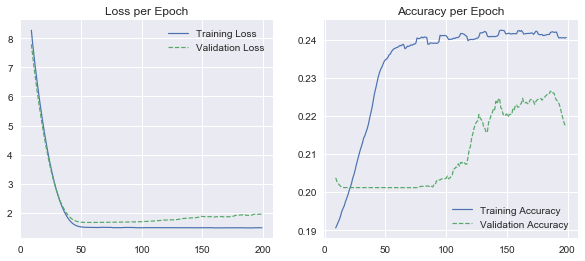

In [43]:
metrics_per_epoch = show_metrics_per_epoch(history, smoothing=True)

### 4.4 모델링 (순환 신경망)
이제 시계열 단위로 학습하게끔 **순환 신경망**으로 모형을 만들어보자. 특정 시점, 특정 종목 수익률을 선택했을 때 **과거 일정 기간의 피쳐 시퀀스를 가져오게끔 제너레이터를 정의**하자. **데이터셋에 없는 단위 시간의 피쳐들은 결측값을 의미하는 -1 값으로 대체**할 것이다.

In [44]:
proc_X_train[['code', 'td']] = X_train[['code', 'td']]
proc_X_valid[['code', 'td']] = X_valid[['code', 'td']]
proc_X_all = pd.concat([proc_X_train, proc_X_valid], axis=0)

In [45]:
def generator(X, y, feature_names, sequence_length=10, shuffle=False, batch_size=128, random_state=42):
    i = 0
    y_copied = y.copy()
    np.random.seed(random_state)
    
    while True:
        indices = np.arange(y_copied.shape[0])
        np.random.shuffle(indices)
        y_copied = y_copied.iloc[indices, :]
    
        if shuffle:
            indices = np.random.randint(0, y_copied.shape[0], size=batch_size)
            
        else:
            if i + batch_size >= y_copied.shape[0]:
                i = 0
            indices = np.arange(i, min(i + batch_size, y_copied.shape[0]))
            i += len(indices)
        
        X_batch = []
        y_batch = y_copied.iloc[indices, :]

        for _, row in y_batch.iterrows():
            n = int(row['td'][1:])
            sequence_of_td = pd.DataFrame({'td': ['T%03d' % j for j in range(
                n, n - sequence_length, -1)][::-1]})
            X_batch.append(sequence_of_td.merge(
                X[X['code'] == row['code']], on='td', how='left')[feature_names].fillna(-1.0).values)
            
        yield np.array(X_batch), y_batch['target'].values

In [46]:
sequence_length = 20
batch_size = 2048

train_generator = generator(proc_X_all, clf_y_train, all_proc_feature_names, 
                            sequence_length=sequence_length, batch_size=batch_size)
valid_generator = generator(proc_X_all, clf_y_valid, all_proc_feature_names, 
                            sequence_length=sequence_length, batch_size=batch_size)

순환 신경망 모형은 우선 **GRU 층으로 시퀀스 피쳐를 처리**한 다음 2개의 완전 연결 층을 추가로 쌓아서 만들었다. **결측값은 학습하지 않고 바로 통과하게끔 마스킹 기법으로 처리**했다. **과적합 방지를 위해 가중치 규제와 (RNN 셀에 대한) 드롭 아웃, 배치 정규화를 설정**했다.

In [47]:
n_features = len(all_proc_feature_names)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_dir, 'best_masked_rnn.h5'), monitor='val_acc', save_best_only=True)]
regularizer = tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)

masked_rnn = tf.keras.models.Sequential()

masked_rnn.add(tf.keras.layers.Masking(mask_value=-1.0, input_shape=(sequence_length, n_features, )))
masked_rnn.add(tf.keras.layers.GRU(64, dropout=0.1, recurrent_dropout=0.1))
masked_rnn.add(tf.keras.layers.Dense(32, kernel_regularizer=regularizer, activation='relu'))
masked_rnn.add(tf.keras.layers.BatchNormalization())
masked_rnn.add(tf.keras.layers.Dropout(0.1, seed=42))
masked_rnn.add(tf.keras.layers.Dense(5, activation='softmax'))

masked_rnn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [48]:
if not os.path.isfile(os.path.join(model_dir, 'masked_rnn.h5')):
    epochs = 100
    steps_per_epoch = clf_y_train.shape[0] // batch_size
    val_steps = clf_y_valid.shape[0] // batch_size

    history = masked_rnn.fit_generator(train_generator, steps_per_epoch, epochs=epochs, 
                                        validation_data=valid_generator, validation_steps=val_steps, 
                                        verbose=False, callbacks=callbacks)
    history = history.history

    masked_rnn.save(os.path.join(model_dir, 'masked_rnn.h5'))
    dump_pickle(os.path.join(model_dir, 'masked_rnn_history.pkl'), history)

else:
    masked_rnn = tf.keras.models.load_model(os.path.join(model_dir, 'masked_rnn.h5'))
    history = load_pickle(os.path.join(model_dir, 'masked_rnn_history.pkl'))

순환 신경망 모형의 경우 기존 완전 연결 신경망 모형 대비 **검증 손실과 정확도를 약간 개선**한다. 반면 **학습 속도는 매우 느리므로** 첫번째 완전 연결 신경망 모형을 최종적으로 선택하겠다. 다만, 순환 신경망 모형은 여러 다른 아키텍쳐와 하이퍼 파라미터로 좀 더 실험해볼 필요가 있다.

검증 손실 최소값: 1.59, 검증 정확도 최대값: 23.97%


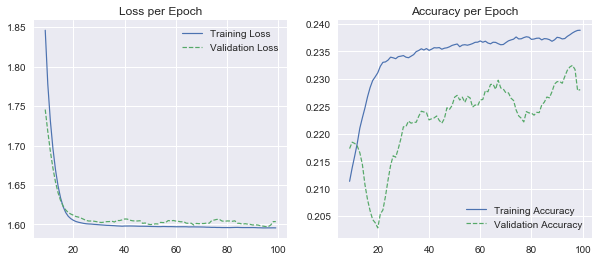

In [49]:
metrics_per_epoch = show_metrics_per_epoch(history, smoothing=True)

# 5. 하이퍼 파라미터 튜닝과 예측값 제출
### 5.1 하이퍼 파라미터 튜닝
모델 프로토타이핑을 통해 최적 아키텍쳐를 선택했으면 층과 유닛의 개수, 가중치 규제 강도, 드롭 아웃 비율, 학습률 등 여러 **하이퍼 파라미터를 튜닝**해야한다. 여기서 **베이즈 최적화 기법을 적용**하여 효율적으로 해를 찾아낼 수 있다. 즉 파라미터 공간과 최적화할 목적 함수를 정의한 다음 해당 기법을 실행하면, 관측한 초기 함수값들을 바탕으로 파라미터 공간을 순차적 탐색한다.

In [50]:
def build_model(n_features, n_classes, n_layers, n_units, l1, l2, dropout_rate, learning_rate):
    regularizer = tf.keras.regularizers.l1_l2(l1=l1, l2=l2)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(n_units, kernel_regularizer=regularizer, activation='relu', 
                                    input_shape=(n_features, )))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate, seed=42))

    if n_layers > 2:
        for _ in range(n_layers - 3):
            model.add(tf.keras.layers.Dense(n_units, kernel_regularizer=regularizer, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(dropout_rate, seed=42))
        
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [51]:
def set_args(space, training_data, validation_data, batch_size, epochs, n_features, n_classes, callbacks):
    @skopt.utils.use_named_args(space)
    
    def _objective(**params):
        model = build_model(n_features, n_classes, **params)
        history = model.fit(*training_data, validation_data=validation_data, 
                             batch_size=batch_size, epochs=epochs, verbose=False, callbacks=callbacks)
        return -1.0 * np.max(history.history['val_acc'])
    
    return _objective

In [52]:
space = [skopt.space.Integer(2, 5, name='n_layers'),
         skopt.space.Integer(1, 128, name='n_units'),
         skopt.space.Real(0.000001, 1.0, name='l1', prior='log-uniform'), 
         skopt.space.Real(0.000001, 1.0, name='l2', prior='log-uniform'), 
         skopt.space.Real(0.0, 0.5, name='dropout_rate', prior='uniform'), 
         skopt.space.Real(0.0001, 1.0, name='learning_rate', prior='log-uniform')]

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, mode='max')]
n_features = len(all_proc_feature_names)
n_classes = 5
training_data = (proc_X_train[all_proc_feature_names], clf_y_train['target'])
validation_data = (proc_X_valid[all_proc_feature_names], clf_y_valid['target'])
batch_size = 16384
epochs = 300

objective = set_args(space, training_data, validation_data, batch_size, epochs, n_features, 5, callbacks)

In [53]:
if not os.path.isfile(os.path.join(model_dir, 'dnn_param_tuning.pkl')):
    results = skopt.forest_minimize(objective, space, base_estimator='ET', acq_func='EI', n_calls=100, 
                                    random_state=42, verbose=False, xi=0.01, n_jobs=1)

    skopt.dump(results, os.path.join(model_dir, 'dnn_param_tuning.pkl'), 
               store_objective=False)
    
else:
    results = skopt.load(os.path.join(model_dir, 'dnn_param_tuning.pkl'))

위 그림에서 보듯이 베이즈 최적화 과정은 반복 횟수 60회가 넘어가면서 최적값에 거의 수렴한다. 중간 그림은 각 파라미터 공간에 대한 탐색 실행 분포와 산점도를 보여준다. 아래 그림은 각 파라미터 값에 대한 검증 정확도의 추정 함수이다. 신경망 층의 개수가 증가할수록, 규제값들은 커질수록 정확도는 감소한다. 반면 일정 수준 이상의 유닛 개수와 드롭 아웃 비율은 정확도에 큰 영향을 주지 않는다. **하이퍼 파라미터 튜닝까지 마친 모형을 검증 정확도를 상식 수준의 기준점에서 약 4%p 이상 향상**시켰다.

층 개수: 2, 유닛 개수: 20, l1 규제값: 0.00%, l2 규제값: 0.00%, 드롭 아웃 비율: 15.46%, 학습률: 0.76%


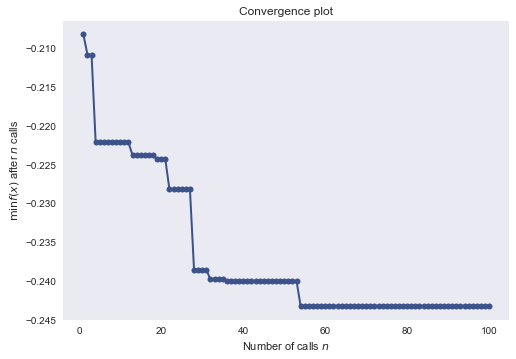

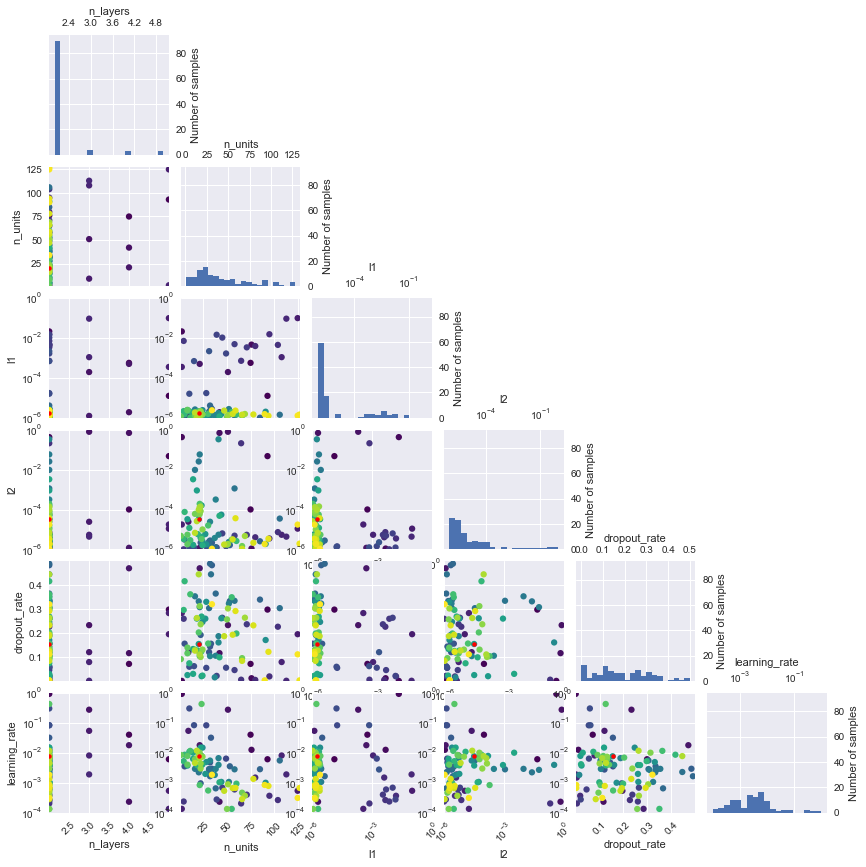

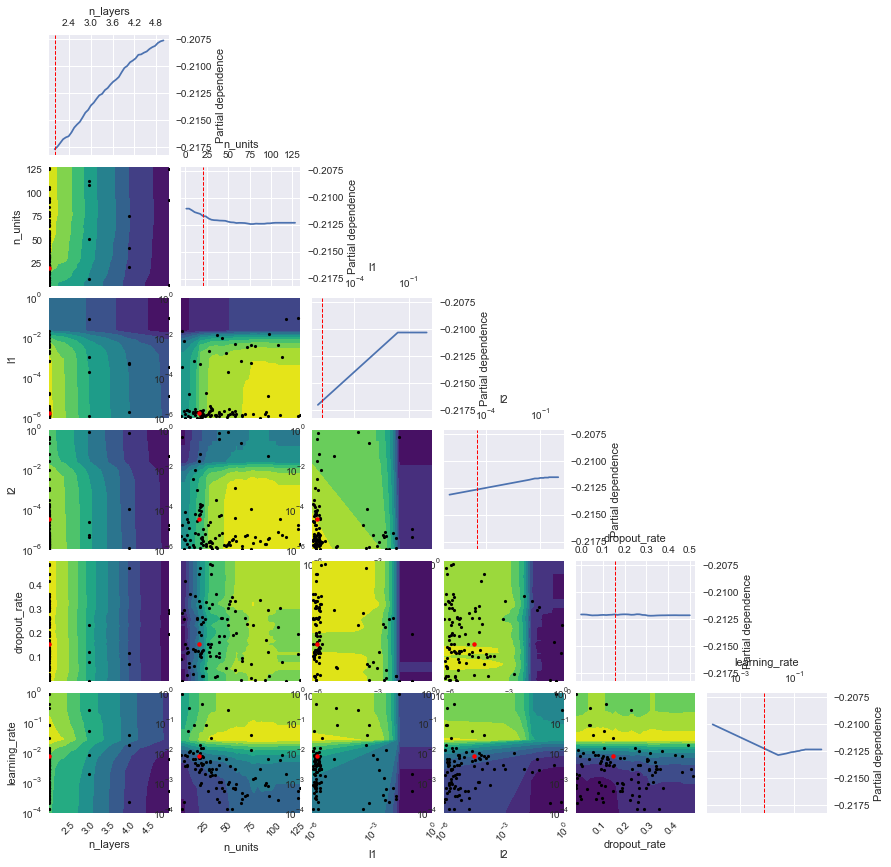

In [54]:
tuned_params = {k: v for k, v in zip(
    ['n_layers', 'n_units', 'l1', 'l2', 'dropout_rate', 'learning_rate'], results.x)}
    
_ = skopt.plots.plot_convergence(results)
_ = skopt.plots.plot_evaluations(results)
_ = skopt.plots.plot_objective(results)

print('층 개수: {}, 유닛 개수: {}, l1 규제값: {:0.2%}, l2 규제값: {:0.2%}, 드롭 아웃 비율: {:0.2%}, 학습률: {:0.2%}'.format(
    tuned_params['n_layers'], tuned_params['n_units'], tuned_params['l1'], tuned_params['l2'],
    tuned_params['dropout_rate'], tuned_params['learning_rate']))

In [55]:
if not os.path.isfile(os.path.join(model_dir, 'tuned_dnn.h5')):
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_tuned_dnn.h5'), monitor='val_acc', save_best_only=True)]

    tuned_dnn = build_model(n_features, n_classes, **tuned_params)
    history = tuned_dnn.fit(*training_data, validation_data=validation_data, 
                             batch_size=batch_size, epochs=epochs, verbose=False, callbacks=callbacks)
    history = history.history

    tuned_dnn.save(os.path.join(model_dir, 'tuned_dnn.h5'))
    dump_pickle(os.path.join(model_dir, 'tuned_dnn_history.pkl'), history)
    
else:
    tuned_dnn = tf.keras.models.load_model(os.path.join(model_dir, 'tuned_dnn.h5'))
    history = load_pickle(os.path.join(model_dir, 'tuned_dnn_history.pkl'))
    
tuned_params['epochs'] = np.argmax(history['val_acc'])

검증 손실 최소값: 1.60, 검증 정확도 최대값: 24.18%


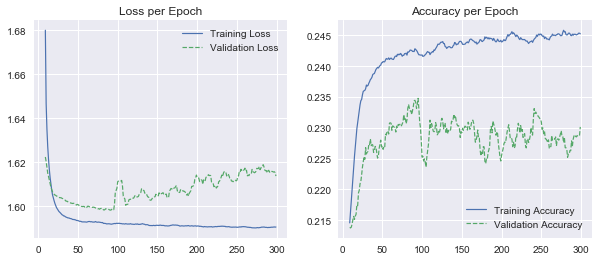

In [56]:
metrics_per_epoch = show_metrics_per_epoch(history, smoothing=True)

### 5.2 예측값 제출
위에서 구한 최적 하이퍼 파라미터와 에폭 횟수로 훈련 데이터셋을 재학습하고 시험 데이터셋에 대해 클래스를 예측하여 저장한다.

In [57]:
X_train = pd.read_csv('./data/train_data.csv') 
clf_y_train = pd.read_csv('./data/train_target2.csv')
X_test = pd.read_csv('./data/test_data.csv') 

X_train = X_train.set_index(['td', 'code'])
clf_y_train = clf_y_train.set_index(['td', 'code'])
X_test = X_test.set_index(['td', 'code'])

In [58]:
proc_X_train = X_train.copy()
proc_X_test = X_test.copy()

In [59]:
skewed_feature_names = sorted(list((proc_X_train[all_feature_names].columns[
    proc_X_train[all_feature_names].skew() > z_score] & (proc_X_train[all_feature_names].columns[
    proc_X_train[all_feature_names].min() > 0.0]))))

proc_X_train[skewed_feature_names] = np.log(1.0 + proc_X_train[skewed_feature_names])
proc_X_test[skewed_feature_names] = np.log(1.0 + proc_X_test[skewed_feature_names])

In [60]:
cat_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value=0.0), 
                             OneHotEncoder(sparse=False, handle_unknown='ignore'))
num_pipeline = make_pipeline(MinMaxScaler(), SimpleImputer(strategy='constant', fill_value=-1.0))
column_transformer = make_column_transformer((cat_pipeline, cat_feature_names), 
                                             (num_pipeline, num_feature_names))

In [61]:
n_categories = X_train[cat_feature_names[0]].nunique() + 1
cat_proc_feature_names = ['_'.join([cat_feature_names[0], str(i)]) for i in range(n_categories)]
all_proc_feature_names = num_feature_names + cat_proc_feature_names

In [62]:
proc_X_train = column_transformer.fit_transform(proc_X_train)
proc_X_train = pd.DataFrame(proc_X_train, columns=all_proc_feature_names, index=X_train.index)

proc_X_test = column_transformer.transform(proc_X_test)
proc_X_test = pd.DataFrame(proc_X_test, columns=all_proc_feature_names, index=X_test.index)

In [63]:
training_data = (proc_X_train[all_proc_feature_names], clf_y_train['target'])
batch_size = 16384
epochs = tuned_params.pop('epochs')

tuned_dnn = build_model(n_features, n_classes, **tuned_params)
history = tuned_dnn.fit(*training_data, batch_size=batch_size, epochs=epochs, verbose=False)

In [64]:
clf_y_test = tuned_dnn.predict(proc_X_test)
submission = pd.DataFrame(np.argmax(clf_y_test, axis=1), columns=['target'], index=proc_X_test.index)

In [65]:
for k, v in (submission['target'].value_counts() / submission.shape[0]).sort_index().iteritems():
    print('클래스 {} 비중 {:>8.2%}'.format(k, v))
    
submission.to_csv('./data/submission.csv')

클래스 0 비중   21.91%
클래스 1 비중   10.51%
클래스 2 비중   39.96%
클래스 3 비중    5.37%
클래스 4 비중   22.25%
